<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-1">Import modules</a></span></li><li><span><a href="#Get-variant-count-by-allele-frequency-bin" data-toc-modified-id="Get-variant-count-by-allele-frequency-bin-2">Get variant count by allele frequency bin</a></span><ul class="toc-item"><li><span><a href="#Counts-for-AF-bins:-0.1%---1%-and->1.0%" data-toc-modified-id="Counts-for-AF-bins:-0.1%---1%-and->1.0%-2.1">Counts for AF bins: <em>0.1% - 1%</em> and <em>&gt;1.0%</em></a></span></li><li><span><a href="#Counts-for-singletons,-doubletons,-and-AF-bins:-doubletons---0.05%,-0.05%---0.1%,-0.1%---1%,-and->1%" data-toc-modified-id="Counts-for-singletons,-doubletons,-and-AF-bins:-doubletons---0.05%,-0.05%---0.1%,-0.1%---1%,-and->1%-2.2">Counts for <em>singletons</em>, <em>doubletons</em>, and AF bins: <em>doubletons - 0.05%</em>, <em>0.05% - 0.1%</em>, <em>0.1% - 1%</em>, and <em>&gt;1%</em></a></span><ul class="toc-item"><li><span><a href="#All-DRD2-variants" data-toc-modified-id="All-DRD2-variants-2.2.1">All DRD2 variants</a></span></li><li><span><a href="#All-DRD2-coding-variants" data-toc-modified-id="All-DRD2-coding-variants-2.2.2">All DRD2 coding variants</a></span></li></ul></li></ul></li><li><span><a href="#Get-the-pLoF-variants-that-we-used-to-compute-constraint-metrics" data-toc-modified-id="Get-the-pLoF-variants-that-we-used-to-compute-constraint-metrics-3">Get the pLoF variants that we used to compute constraint metrics</a></span></li></ul></div>

## Import modules

In [1]:
import hail as hl

from gnomad_toolbox.analysis.general import get_variant_count_by_freq_bin
from gnomad_toolbox.filtering.variant import filter_by_intervals
from gnomad_toolbox.filtering.vep import filter_by_consequence_category
from gnomad_toolbox.filtering.constraint import get_observed_plofs_for_gene_constraint
from gnomad_toolbox.load_data import get_gnomad_release

Loading BokehJS ...

In [2]:
hl.init(backend="local")

Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.133-4c60fddb171a
LOGGING: writing to /Users/heqin/PycharmProjects/gnomad-toolbox/gnomad_toolbox/notebooks/hail-20250303-1146-0.2.133-4c60fddb171a.log


## Get variant count by allele frequency bin

The examples below show variant counts using the Table filtered to DRD2.

### Counts for AF bins: *0.1% - 1%* and *>1.0%*

In [4]:
drd_interval_ht = filter_by_intervals(
    "chr11:113409605-113475691")
af_bin_ht = get_variant_count_by_freq_bin(
    ht=drd_interval_ht)
print(af_bin_ht)

{'0.1% - 1.0%': 49, '>1.0%': 28, 'AC0 - 0.1%': 2662}


### Counts for *singletons*, *doubletons*, and AF bins: *doubletons - 0.05%*, *0.05% - 0.1%*, *0.1% - 1%*, and *>1%*

#### All DRD2 variants

In [4]:
af_bin_ht = get_variant_count_by_freq_bin(
    af_cutoffs=[0.0005, 0.001, 0.01], 
    singletons=True, 
    doubletons=True, 
    ht=drd_interval_ht,
)
print(af_bin_ht)

{'0.05% - 0.1%': 11, '0.1% - 1.0%': 34, '>1.0%': 26, 'doubletons': 384, 'doubletons - 0.05%': 894, 'singletons': 1390}


#### All DRD2 coding variants

In [9]:
af_bin_ht = get_variant_count_by_freq_bin(
    af_cutoffs=[0.0005, 0.001, 0.01], 
    singletons=True, 
    doubletons=True, 
    ht=filter_by_consequence_category(
        ['coding'], 
        ht=drd_interval_ht),
)
print(af_bin_ht)

NameError: name 'LOF_CSQ_SET' is not defined

In [10]:
from gnomad.utils.filtering import filter_gencode_ht
from gnomad.utils.vep import (
    LOF_CSQ_SET,
    filter_vep_transcript_csqs,
    filter_vep_transcript_csqs_expr,
)

from gnomad_toolbox.load_data import _get_dataset, get_compatible_dataset_versions

def filter_by_consequence_category(
    plof: bool = False,
    missense: bool = False,
    synonymous: bool = False,
    other: bool = False,
    pass_filters: bool = True,
    **kwargs,
) -> hl.Table:
    """
    Filter gnomAD variants based on VEP consequence.

    https://gnomad.broadinstitute.org/help/consequence-category-filter

    The [VEP](https://useast.ensembl.org/info/docs/tools/vep/index.html) consequences included in each category are:

        pLoF:

            - transcript_ablation
            - splice_acceptor_variant
            - splice_donor_variant
            - stop_gained
            - frameshift_variant

        Missense / Inframe indel:

            - stop_lost
            - start_lost
            - inframe_insertion
            - inframe_deletion
            - missense_variant

        Synonymous:

            - synonymous_variant

        Other:

            - All other consequences not included in the above categories.

    :param plof: Whether to include pLoF variants.
    :param missense: Whether to include missense variants.
    :param synonymous: Whether to include synonymous variants.
    :param other: Whether to include other variants.
    :param pass_filters: Boolean if the variants pass the filters.
    :param kwargs: Arguments to pass to `_get_dataset`.
    :return: Table with variants with the specified consequences.
    """
    if not any([plof, missense, synonymous, other]):
        raise ValueError(
            "At least one of plof, missense, synonymous, or other must be True."
        )

    # Load the Hail Table if not provided
    ht = _get_dataset(dataset="variant", **kwargs)

    lof_csqs = list(LOF_CSQ_SET) + ["transcript_ablation"]
    missense_csqs = [
        "missense_variant",
        "inframe_insertion",
        "inframe_deletion",
        "stop_lost",
        "start_lost",
    ]
    synonymous_csqs = ["synonymous_variant"]
    other_csqs = lof_csqs + missense_csqs + synonymous_csqs

    csqs = (
        (lof_csqs if plof else [])
        + (missense_csqs if missense else [])
        + (synonymous_csqs if synonymous else [])
    )

    filter_expr = None

    if csqs:
        filter_expr = filter_vep_transcript_csqs_expr(ht.vep, csqs=csqs)

    if other:
        other_expr = filter_vep_transcript_csqs_expr(
            ht.vep, csqs=other_csqs, keep_csqs=False
        )
        filter_expr = other_expr if filter_expr is None else (filter_expr | other_expr)

    if pass_filters:
        pass_expr = hl.len(ht.filters) == 0
        filter_expr = pass_expr if filter_expr is None else (filter_expr & pass_expr)

    return ht.filter(filter_expr)

## Get the pLoF variants that we used to compute constraint metrics

The pLOF variant count displayed on the browser meets the following requirements:

        - PASS variant QC
        - SNV
        - Allele frequency ≤ 0.1%
        - High-confidence LOFTEE in the MANE Select or Canonical transcript
        - ≥ a specified coverage threshold (depends on the version)

**Note: this number should match the number of observed pLOF SNVs on the gene page of gnomAD Browser.**

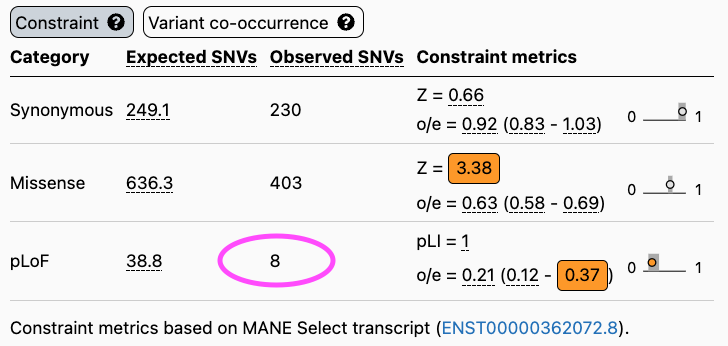

In [ ]:
get_observed_plofs_for_gene_constraint('drd2').show(-1)